In [1]:
#Imports
import xml.etree.ElementTree as ET
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import sklearn
from skimage import filters
from skimage import data
from skimage import io
from skimage.color import rgb2gray
from pathlib import Path
from PIL import Image
import sklearn.metrics
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import json

In [2]:
def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text) 
        ymin = int(bndbox.find('ymin').text) 
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin, ymin, xmax, ymax)) 
    return bbox 

In [3]:
def crop_images(image_files, annotation_files, target_directory):
    for i in range(len(image_files)):
        bbox = get_bounding_boxes(annotation_files[i])
        dog_image_path = image_files[i]
        im = Image.open(dog_image_path)
        
        for j, box in enumerate(bbox):
            im2 = im.crop(box)
            im2 = im2.resize((128, 128), Image.LANCZOS)
            
            new_path = dog_image_path.replace('data/images', target_directory)
            new_path = new_path.replace('.jpg', f'-{j}.jpg')
            im2 = im2.convert('RGB')
            
            head, _ = os.path.split(new_path)
            Path(head).mkdir(parents=True, exist_ok=True)
            
            im2.save(new_path)

In [4]:
def angle(dx, dy):
    return np.mod(np.arctan2(dy,dx), np.pi)

In [5]:
#Crop the images using the boundaries
crop_images(glob.glob(os.path.join(r'data/images/n02093647-Bedlington_terrier','*.jpg')),
            glob.glob(os.path.join(r'data/annotations/n02093647-Bedlington_terrier', '*')),
            './data/cropped/class1')
crop_images(glob.glob(os.path.join(r'data/images/n02099849-Chesapeake_Bay_retriever','*.jpg')),
            glob.glob(os.path.join(r'data/annotations/n02099849-Chesapeake_Bay_retriever', '*')),
            './data/cropped/class2')
crop_images(glob.glob(os.path.join(r'data/images/n02100735-English_setter','*.jpg')),
            glob.glob(os.path.join(r'data/annotations/n02100735-English_setter', '*')),
            './data/cropped/class3')
crop_images(glob.glob(os.path.join(r'data/images/n02116738-African_hunting_dog','*.jpg')),
            glob.glob(os.path.join(r'data/annotations/n02116738-African_hunting_dog', '*')),
            './data/cropped/class4')

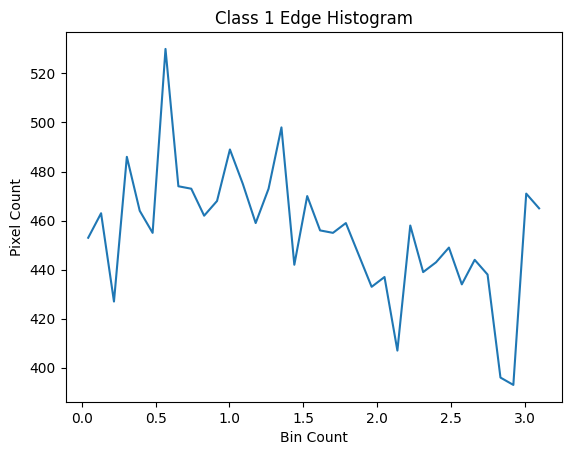

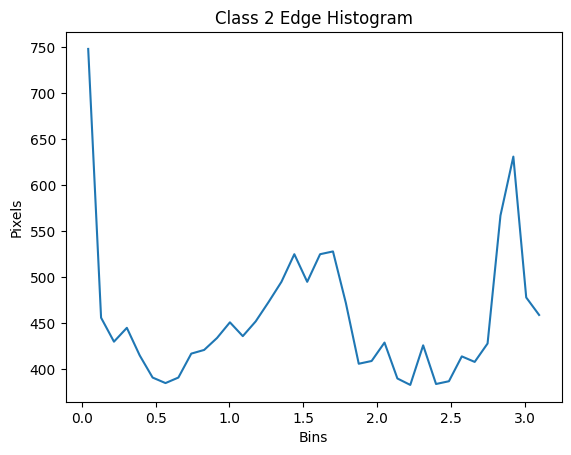

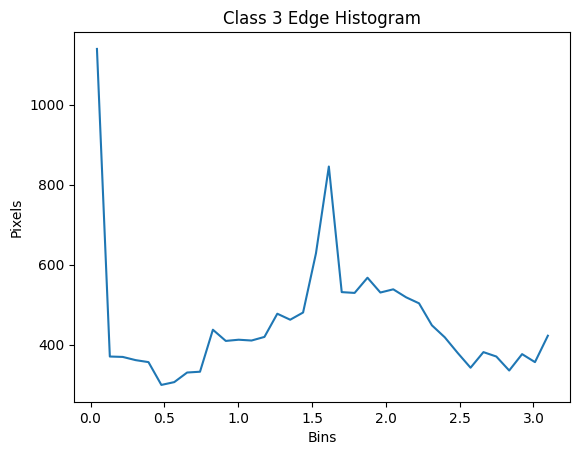

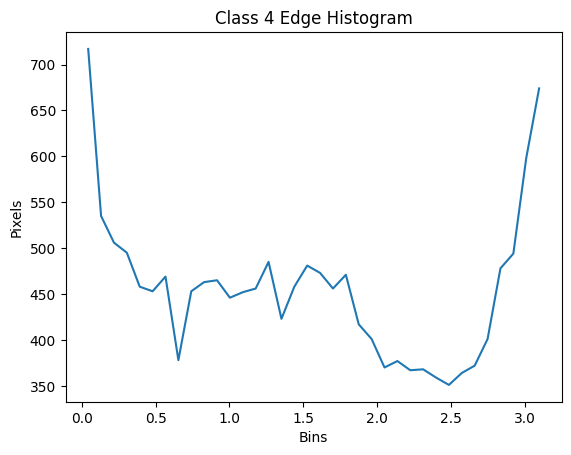

In [6]:
#Feature Extraction: Edge Histogram and Similarity Measurements
#Choosing one random Image from each class
randomImage1= random.choice(glob.glob(os.path.join(r'data/cropped/class1/n02093647-Bedlington_terrier','*jpg')))
randomImage2 = random.choice(glob.glob(os.path.join(r'data/cropped/class2/n02099849-Chesapeake_Bay_retriever','*jpg')))
randomImage3 = random.choice(glob.glob(os.path.join(r'data/cropped/class3/n02100735-English_setter','*jpg')))
randomImage4 = random.choice(glob.glob(os.path.join(r'data/cropped/class4/n02116738-African_hunting_dog','*jpg')))

#Convert Each Random Image to Grayscale
grayScale1 = rgb2gray(io.imread(randomImage1))
grayScale2 = rgb2gray(io.imread(randomImage2))
grayScale3 = rgb2gray(io.imread(randomImage3))
grayScale4 = rgb2gray(io.imread(randomImage4))

#Calculate angle sobel for each image
angleSobel1 = angle(filters.sobel_h(grayScale1),filters.sobel_v(grayScale1))
angleSobel2 = angle(filters.sobel_h(grayScale2),filters.sobel_v(grayScale2))
angleSobel3 = angle(filters.sobel_h(grayScale3),filters.sobel_v(grayScale3))
angleSobel4 = angle(filters.sobel_h(grayScale4),filters.sobel_v(grayScale4))

#Edge Histogram
histogram1, bin1 = ski.exposure.histogram(angleSobel1, nbins=36)
histogram2, bin2 = ski.exposure.histogram(angleSobel2, nbins=36)
histogram3, bin3 = ski.exposure.histogram(angleSobel3, nbins=36)
histogram4, bin4 = ski.exposure.histogram(angleSobel4, nbins=36)

#Plot the images with their corresponding edge histogram value
#Class1
plt.figure()
plt.plot(bin1, histogram1)
plt.xlabel("Bin Count")
plt.ylabel("Pixel Count")
plt.title("Class 1 Edge Histogram")
plt.fill()
plt.show()
#Class2
plt.figure()
plt.plot(bin2, histogram2)
plt.xlabel("Bins")
plt.ylabel("Pixels")
plt.title("Class 2 Edge Histogram")
plt.fill()
plt.show()
#Class3
plt.figure()
plt.plot(bin3, histogram3)
plt.xlabel("Bins")
plt.ylabel("Pixels")
plt.title("Class 3 Edge Histogram")
plt.fill()
plt.show()
#Class4
plt.figure()
plt.plot(bin4, histogram4)
plt.xlabel("Bins")
plt.ylabel("Pixels")
plt.title("Class 4 Edge Histogram")
plt.fill()
plt.show()

In [7]:
#Pick 2 edge histograms from the 4 you have constructed and perform histogram between the 2 edge histograms
#We will use histogram 2 and histogram 3 for this example

#Euclidean Distance
euclideanDistance = sklearn.metrics.pairwise.euclidean_distances([histogram2],[histogram3])
#Manhattan Distance
manhattanDistance = sklearn.metrics.pairwise.manhattan_distances([histogram2],[histogram3])
#Cosine
cosineDistance = sklearn.metrics.pairwise.cosine_distances([histogram2],[histogram3])
print(f"Euclidean Distance: {euclideanDistance[0][0]:.2f}")
print(f"Manhattan Distance: {manhattanDistance[0][0]:.2f}")
print(f"Cosine Distance: {cosineDistance[0][0]:.2f}")

Euclidean Distance: 748.43
Manhattan Distance: 3238.00
Cosine Distance: 0.03


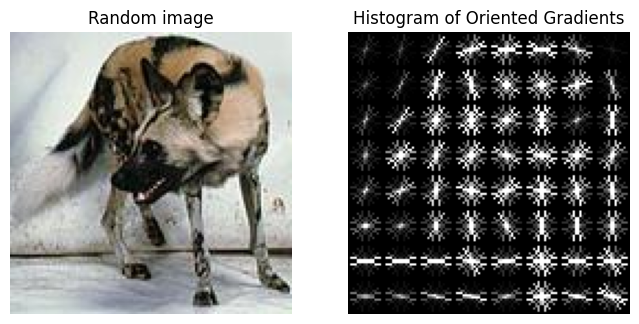

In [8]:
#Histogram of Oriented Gradient(Hog)
#Picking one image to compute its HOGH descriptors
fd, image = ski.feature.hog(io.imread(randomImage4),orientations = 8,pixels_per_cell=(16,16),cells_per_block=(1,1),visualize=True,channel_axis=-1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(io.imread(randomImage4), cmap=plt.cm.gray)
ax1.set_title('Random image')

ax2.axis('off')
ax2.imshow(ski.exposure.rescale_intensity(image, in_range=(0, 10)), cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [9]:
#Dimensionality reduction (using Principal Component Analysis, PCA)
#Convert all the images from all classes into edge histograms
class1Directory = 'data/cropped/class1/n02093647-Bedlington_terrier'
class2Directory = 'data/cropped/class2/n02099849-Chesapeake_Bay_retriever'
class3Directory = 'data/cropped/class3/n02100735-English_setter'
class4Directory = 'data/cropped/class4/n02116738-African_hunting_dog'

masterDirectory = [class1Directory, class2Directory, class3Directory, class4Directory]
masterHistograms = []
masterLabels = []

for class_idx, class_dir in enumerate(masterDirectory):
    for filename in os.listdir(class_dir):
        if filename.endswith((".jpg")):
            image_path = os.path.join(class_dir, filename)
            image = io.imread(image_path)
            image = rgb2gray(image)
            sobel_h = filters.sobel_h(image)
            sobel_v = filters.sobel_v(image)
            angles = angle(sobel_h, sobel_v)
            hist, nbin = ski.exposure.histogram(angles, nbins=36)
            hist = hist / np.sum(hist)
            masterHistograms.append(hist)
            masterLabels.append(class_idx)

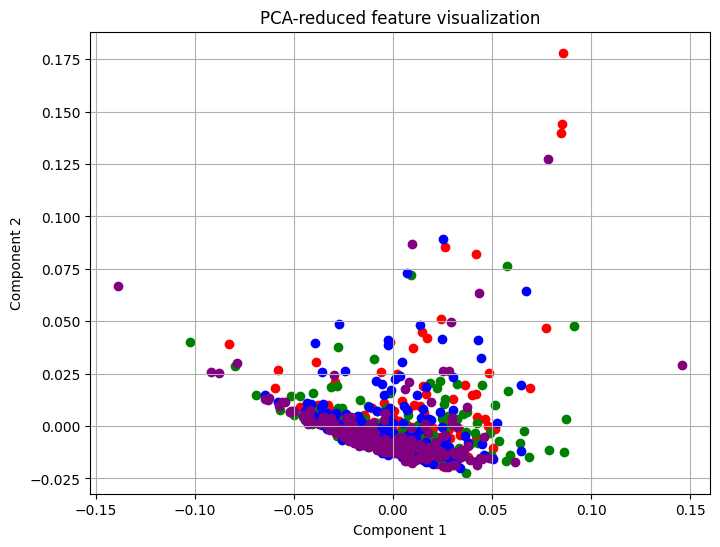

In [10]:
#Dimensionality reduction from 36 to 2
histograms = np.array(masterHistograms)
labels = np.array(masterLabels)
pca = PCA(n_components=2)
histograms_pca = pca.fit_transform(histograms)
plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue', 'purple']
for i in range(4):
    class_data = histograms_pca[labels == i]
    plt.scatter(class_data[:, 0], class_data[:, 1], color=colors[i], label=f'Class {i}')
plt.title('PCA-reduced feature visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

How many classes are visually separable (i.e., non-overlapping)?
There seems to be no classes visually seperable. All 4 classes seem to be overlapping.

Dimensionality of countvectorizer is  (2701, 4)
Dimensionality of TF-IDF: (2701, 4)


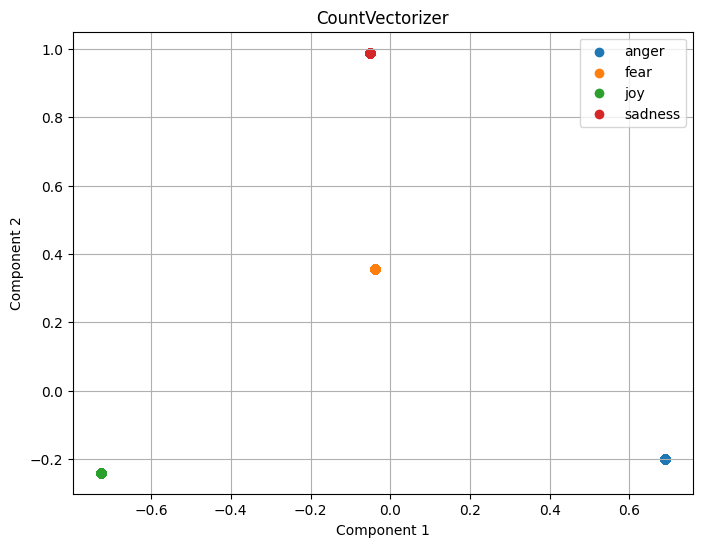

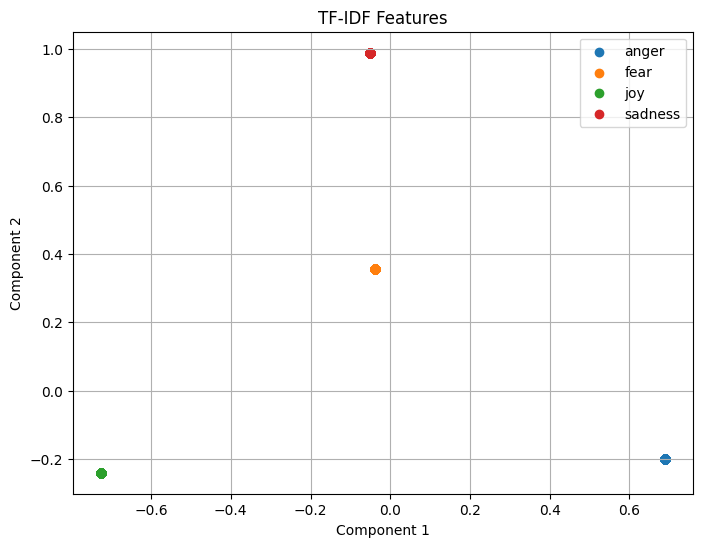

In [11]:
#4 Classes of emotions I have selected
selected_emotions = ['anger', 'joy', 'sadness', 'fear']
json_file_path = 'train.json'
labels = []

with open(json_file_path, 'r') as file:
    for line in file:
        data = json.loads(line)
        tweet_labels = [emotion for emotion in selected_emotions if data.get(emotion)]
        if tweet_labels:
            labels.append(tweet_labels[0])
count = CountVectorizer()
tfidf = TfidfVectorizer()
countFeatures = count.fit_transform(labels)
tfidfFeatures = tfidf.fit_transform(labels)
print(f"Dimensionality of countvectorizer is  {countFeatures.shape}")
print(f"Dimensionality of TF-IDF: {tfidfFeatures.shape}")
tfidfFeatures = tfidf.fit_transform(labels)

pca = PCA(n_components=2)
count_features_2d = pca.fit_transform(countFeatures.toarray())
tfidf_features_2d = pca.fit_transform(tfidfFeatures.toarray())

unique_labels = np.unique(labels)
plt.figure(figsize=(8, 6))
for class_label in unique_labels:
    indices = [i for i, label in enumerate(labels) if label == class_label]
    plt.scatter(count_features_2d[indices, 0], count_features_2d[indices, 1], label=class_label)

plt.title('CountVectorizer')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
for class_label in unique_labels:
    indices = [i for i, label in enumerate(labels) if label == class_label]
    plt.scatter(tfidf_features_2d[indices, 0], tfidf_features_2d[indices, 1], label=class_label)

plt.title('TF-IDF Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)
plt.show()


Plot the 2D points using four different colors for data from the four classes (see Figure 1) for both
token count features and tf-idf features in two separate plots.

How many classes are visually separable (i.e., non-overlapping) for both plots? All the classes are visually seperable.